# MALARIA CASE PREDICTION FOR ABUJA AND KANO

In [ ]:
pip install pyspatialml lazypredict rasterio raster4ml

### Import necessary libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import glob
import tempfile
from pathlib import Path

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import randint, uniform

import rasterio
import cv2
from raster4ml.preprocessing import stack_bands
from raster4ml.plotting import Map
from pyspatialml import Raster

In [ ]:
# Folium for mapping
import folium
from folium.plugins import MarkerCluster

# Statsmodels for statistical analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
# Scikit-learn for machine learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor
)
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import mutual_info_classif, RFE, f_classif
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    make_scorer
)

# XGBoost and LightGBM
import xgboost as xgb
import lightgbm as lgb

# Joblib for model saving/loading
from joblib import dump, load

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# Lazy Predict for quick benchmarking
import lazypredict
from lazypredict.Supervised import LazyRegressor


## Malaria Prediction for Abuja

### Load data from CSV file

In [ ]:
file_path = "Wards.shp"
df = gpd.read_file(file_path)

### Display the first few rows of the dataset

In [ ]:
df.head()

,ogc_fid,rowid,ogc_fid0,wardcode,wardname,lgacode,urban,source,editor,timestamp,...,lganame,statename,ratio,print orie,cases_2023,cases_2024,Rainfall,LST,Relative_H,geometry
0,395.00,490327.00,490327.00,KN2103,Gandu Albasa,20043,No,INEC,oluseye.abraham,2019-03-16T20:19:44+01:00,...,Kano Municipal,Kano,0.94,Portrait,6631.00,6096.00,50.04,1079.17,1493.45,"POLYGON ((8.51672 11.9552, 8.51661 11.95525, 8..."
1,519.00,490506.00,490506.00,KN2609,Shuwaki,20042,No,INEC,oluseye.abraham,2019-03-16T20:19:44+01:00,...,Kunchi,Kano,1.09,Landscape,3073.00,1432.00,77.09,1029.81,1612.91,"POLYGON ((8.10816 12.41637, 8.13017 12.44115, ..."
2,1181.00,491621.00,491621.00,KN3611,Sumaila,20011,No,INEC,oluseye.abraham,2019-03-16T20:19:44+01:00,...,Sumaila,Kano,1.21,Landscape,2954.00,1930.00,35.61,1077.77,1451.16,"POLYGON ((8.96357 11.47936, 8.96237 11.49045, ..."
3,1208.00,491664.00,491664.00,KN0109,Toranke,20004,No,INEC,oluseye.abraham,2019-03-16T20:19:44+01:00,...,Ajingi,Kano,0.60,Portrait,4365.00,3188.00,48.32,1098.11,1402.32,"MULTIPOLYGON (((9.10413 11.9047, 9.10632 11.90..."
4,1232.00,491708.00,491708.00,KN4008,Yankamaye,20008,No,INEC,oluseye.abraham,2019-03-16T20:19:44+01:00,...,Tsanyawa,Kano,1.29,Landscape,5511.00,3627.00,77.39,1035.97,1591.63,"POLYGON ((7.90273 12.33248, 7.91856 12.33585, ..."


In [ ]:
df.dtypes

,0
ogc_fid,float64
rowid,float64
ogc_fid0,float64
wardcode,object
wardname,object
lgacode,object
urban,object
source,object
editor,object
timestamp,object


In [ ]:
# Replace NaN or None with 0 (or another appropriate value based on your context)
df['cases_2023'] = df['cases_2023'].fillna(0)

In [ ]:
## Plotting on map

In [ ]:
# Get minimum (0) and maximum values from 2023_Cases
min_cases = 0  # Explicitly setting 0 as the minimum for green
max_cases = df['cases_2023'].max()

# Normalize the 2023_Cases column for color scaling
norm = mcolors.Normalize(vmin=min_cases, vmax=max_cases)

# Create a colormap that goes from green (low) to red (high)
colormap = mcolors.LinearSegmentedColormap.from_list("case_colormap", ["green","yellow", "red"])

# Function to assign colors based on the number of 2023 cases
def get_color(cases):
    return mcolors.to_hex(colormap(norm(cases)))

# Create a Folium map centered on the mean of the polygon coordinates
m = folium.Map(location=[df.geometry.centroid.y.mean(), df.geometry.centroid.x.mean()], zoom_start=10, width='50%', height='50%')

# Add polygons to the map with color based on 2023_Cases and display value on hover
folium.GeoJson(
    df,
    name="polygons",
    style_function=lambda feature: {
        'fillColor': get_color(feature['properties']['cases_2023']),
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7
    },
    highlight_function=lambda feature: {
        'weight': 3,
        'fillOpacity': 0.9
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['cases_2023'],
        aliases=['cases_2023:'],
        localize=True
    )
).add_to(m)

# Display the map
m

Output hidden; open in https://colab.research.google.com to view.

### Define features and target variable

In [ ]:
features = ['Rainfall', 'LST', 'Relative_H']
target = 'cases_2023'

### Prepare feature matrix X and target vector y

In [ ]:
X = df[features]
y = df[target]

In [ ]:
#lazypredict

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=200)

clf = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

100%|██████████| 42/42 [00:03<00:00, 10.60it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 439
[LightGBM] [Info] Number of data points in the train set: 436, number of used features: 3
[LightGBM] [Info] Start training from score 4648.502294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [ ]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.37,0.38,5346.93,0.30
RandomForestRegressor,0.33,0.35,5498.32,0.41
ExtraTreesRegressor,0.32,0.34,5538.73,0.33
BaggingRegressor,0.31,0.33,5592.43,0.07
LGBMRegressor,0.21,0.23,5990.40,0.13
HistGradientBoostingRegressor,0.20,0.23,5997.36,0.26
AdaBoostRegressor,0.10,0.12,6387.44,0.08
XGBRegressor,0.04,0.07,6589.51,0.37
KNeighborsRegressor,-0.01,0.02,6742.47,0.02


### Split data into training and testing sets
*0.2 means variable splitted into 80% train and 20% Test*

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=200)


# Scaling the features

scaler = StandardScaler()
scaler_rf = StandardScaler()
x_train_scaled = scaler_rf.fit_transform(X_train)
x_test_scaled = scaler_rf.transform(X_test)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Recursive Feature Elimination (RFE)
The RFE (Recursive Feature Elimination) rankings indicate the importance of features based on their contribution to predicting the target variable (Cases)- I as highest rank

In [ ]:
# Use RandomForestRegressor as the estimator for RFE
rfe_estimator = RandomForestRegressor(random_state=42)

# Initialize Recursive Feature Elimination (RFE) to select 2 features
rfe = RFE(estimator=rfe_estimator, n_features_to_select=2)

# Fit RFE to the training data
rfe.fit(X_train, y_train)

# Create a DataFrame to display RFE results
rfe_df = pd.DataFrame({
    'Feature': features,
    'RFE Ranking': rfe.ranking_
}).sort_values(by='RFE Ranking')

# Display the RFE Feature Rankings
print("RFE Feature Rankings:")
print(rfe_df)

RFE Feature Rankings:
      Feature  RFE Ranking
0    Rainfall            1
1         LST            1
2  Relative_H            2


# Random Forest

In [ ]:
# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=200)


# Train the model
rf.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=200)

In [ ]:
# Save the model

dump(rf, 'Models/Non Clinical/model/random_forest.joblib')

['/content/drive/MyDrive/Colab Notebooks/Malaria modeling and Prediction/models/random_forest.joblib']

In [ ]:
# Save the model Scaler

In [ ]:
dump(scaler_rf, 'Models/Non Clinical/model/scaler_rf.joblib')

['/content/drive/MyDrive/Colab Notebooks/Malaria modeling and Prediction/models/scaler_rf.joblib']

In [ ]:
# Load the model

best_random_forest = load('Models/Non Clinical/model/random_forest.joblib')

In [ ]:
# prompt: load scaler and fit to model

from joblib import dump, load

# Load the scaler
scaler = load('Models/Non Clinical/model/scaler_rf.joblib')

# Example usage: Assuming you have new data 'new_data'
# new_data_scaled = scaler.transform(new_data)

# Load the model
best_random_forest = load('Models/Non Clinical/model/random_forest.joblib')

# Example usage: Predict using the loaded model
# predictions = best_random_forest.predict(new_data_scaled)

In [ ]:
# Retrieve feature importance from the model

importances = best_random_forest.feature_importances_

# Match Feature Importances with Feature Names

feature_names = X_train.columns

feature_importance_dict = dict(zip(feature_names, importances))

# Sort the features by importance
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

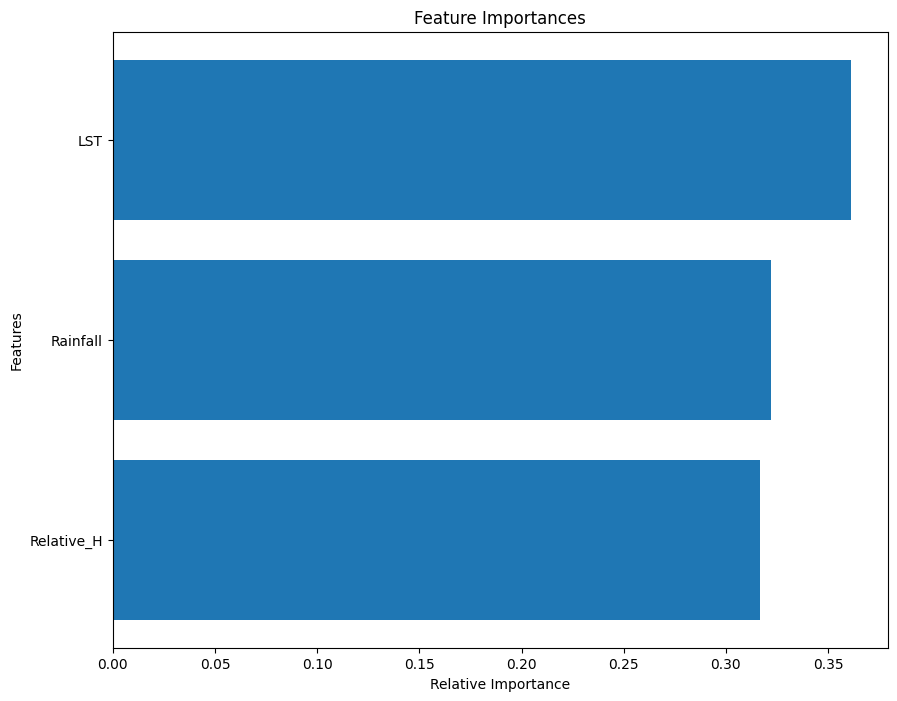

In [ ]:
# Extract feature names and their importance values
features, importance = zip(*sorted_feature_importance)

plt.figure(figsize=(10, 8))
plt.barh(features, importance)
plt.xlabel("Relative Importance")
plt.ylabel("Features")
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

In [ ]:
random_forest_pred = rf.predict(X_test_scaled)

In [ ]:
# Evaluation metrics

mae = mean_absolute_error(y_test, random_forest_pred)
mse = mean_squared_error(y_test, random_forest_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(y_test, random_forest_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"_Root Mean Squared Error (RMSE)_: {rmse}")
print(f"R-squared (R2): {r2}")

Mean Absolute Error (MAE): 3664.327636363637
Mean Squared Error (MSE): 30500325.948974546
_Root Mean Squared Error (RMSE)_: 5522.7100185483705
R-squared (R2): 0.34327144406784704


## Gradient Boosting Machines: XGBoost

In [ ]:
# Initialize the GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=200)

# Train the model
gbr.fit(X_train, y_train)

GradientBoostingRegressor(random_state=200)

In [ ]:
# Save the model

dump(gbr, 'Models/Non Clinical/model/gbr-model.joblib')

['/content/drive/MyDrive/Colab Notebooks/Malaria modeling and Prediction/models/gbr-model.joblib']

In [ ]:
# Load the model

gbr = load('Models/Non Clinical/model/gbr-model.joblib')

In [ ]:
# Retrieve feature importance from the model

feature_importances = gbr.feature_importances_

# Match feature names with their importances

importance_dict = dict(zip(feature_names, feature_importances))

# Sort features by importance
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

# Unpacking for plotting
sorted_features, sorted_scores = zip(*sorted_importance)

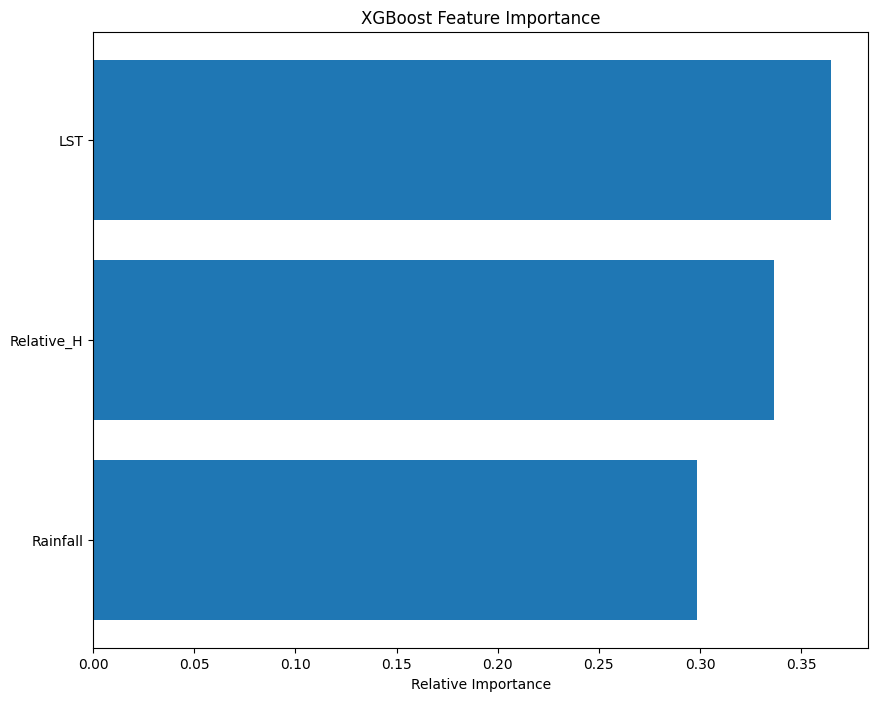

In [ ]:
# The plot
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_features)), sorted_scores, align='center')
plt.yticks(range(len(sorted_features)), sorted_features)
plt.gca().invert_yaxis()  # Most important at the top
plt.xlabel('Relative Importance')
plt.title('XGBoost Feature Importance')
plt.show()

In [ ]:
gbr_pred = gbr.predict(X_test_scaled)

In [ ]:
# Evaluation metrics

mae = mean_absolute_error(y_test, gbr_pred)
mse = mean_squared_error(y_test, gbr_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(y_test, gbr_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"_Root Mean Squared Error (RMSE)_: {rmse}")
print(f"R-squared (R2): {r2}")

Mean Absolute Error (MAE): 19649.608182757118
Mean Squared Error (MSE): 415356185.5777763
_Root Mean Squared Error (RMSE)_: 20380.289143625425
R-squared (R2): -7.9433886184797124


## Gradient Boosting Machines: LightGBM

In [ ]:
# Updated parameter distribution with smaller min_child_samples and min_data_in_bin
lgb_param_dist = {
    'num_leaves': randint(20, 200),
    'min_child_samples': randint(5, 20),  # Reduced range for small dataset
    'min_child_weight': [1e-5, 1e-3, 0.1, 1, 100],
    'subsample': uniform(loc=0.2, scale=0.8),  # Bagging fraction
    'colsample_bytree': uniform(loc=0.4, scale=0.6),  # Feature fraction
    'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50],  # L1 regularization
    'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50],  # L2 regularization
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
}

In [ ]:
# Initialize the LightGBM regressor
lgb_reg = lgb.LGBMRegressor(random_state=200, n_estimators=500)

# Randomized search with updated parameter ranges
lgb_random_search = RandomizedSearchCV(
    estimator=lgb_reg,
    param_distributions=lgb_param_dist,
    n_iter=10,  # Increased for better exploration
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the model
lgb_random_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 439
[LightGBM] [Info] Number of data points in the train set: 436, number of used features: 3
[LightGBM] [Info] Start training from score 4648.502294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

RandomizedSearchCV(cv=5,
                   estimator=LGBMRegressor(n_estimators=500, random_state=200),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a983701ebf0>,
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'min_child_samples': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a983701d600>,
                                        'min_child_weight': [1e-05, 0.001, 0.1,
                                                             1, 100],
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a983701d120>,
                                        'reg_alpha': [0, 0.1, 1, 2, 5, 7, 10,
                                                      50],
                                        'reg_lambda': [0, 0.1, 1, 5, 10, 20,
                                                       50],
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a983701cd00>},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [ ]:
# The best estimator

best_lgb = lgb_random_search.best_estimator_

In [ ]:
# Save the model

dump(best_lgb, 'Models/Non Clinical/model/light-gbm-model.joblib')

['/content/drive/MyDrive/Colab Notebooks/Malaria modeling and Prediction/models/light-gbm-model.joblib']

In [ ]:
# Load the model

best_lgb = load('Models/Non Clinical/model/light-gbm-model.joblib')

In [ ]:
# Retrieve feature importances from the model

feature_importances = best_lgb.feature_importances_

# Sort the feature importances in descending order

sorted_indices = np.argsort(feature_importances)[::-1]

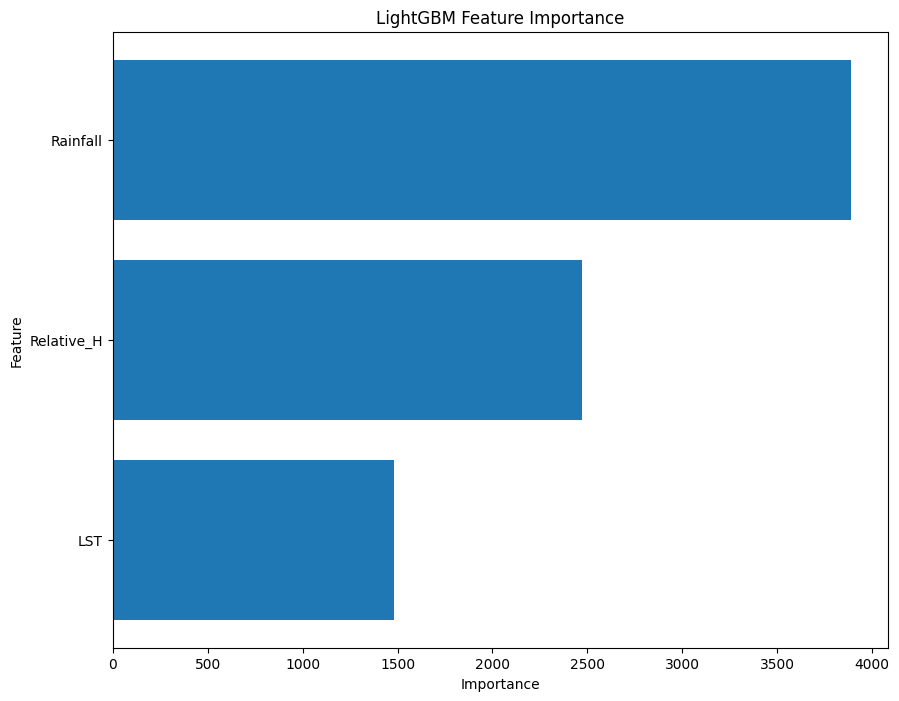

In [ ]:
# The plot

plt.figure(figsize=(10, 8))
plt.title("LightGBM Feature Importance")

# Use barh for horizontal bars
plt.barh(range(len(sorted_indices)), feature_importances[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), feature_names[sorted_indices])

# Invert the y-axis to have the highest importance at the top
plt.gca().invert_yaxis()

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
lgb_pred = best_lgb.predict(X_test_scaled)

In [ ]:
# Evaluation metrics

mae = mean_absolute_error(y_test, lgb_pred)
mse = mean_squared_error(y_test, lgb_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(y_test, lgb_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"_Root Mean Squared Error (RMSE)_: {rmse}")
print(f"R-squared (R2): {r2}")

Mean Absolute Error (MAE): 4070.0118693427344
Mean Squared Error (MSE): 40566241.99490335
_Root Mean Squared Error (RMSE)_: 6369.163366950431
R-squared (R2): 0.12653361247757955


## ExtraTreesRegressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing

In [ ]:
# Initialize the model
etr = ExtraTreesRegressor(random_state=200)

In [ ]:
# Train the model
etr.fit(X_train, y_train)

ExtraTreesRegressor(random_state=200)

In [ ]:
# Save the model
dump(etr, 'Models/Non Clinical/model/ExtraTreesRegressor.joblib')

['/content/drive/MyDrive/Colab Notebooks/Malaria modeling and Prediction/models/ExtraTreesRegressor.joblib']

In [ ]:
# Load the model

etr = load('Models/Non Clinical/model/ExtraTreesRegressor.joblib')

In [ ]:
# Retrieve feature importance from the model

importances = etr.feature_importances_

# Match Feature Importances with Feature Names

feature_names = X_train.columns

feature_importance_dict = dict(zip(feature_names, importances))

# Sort the features by importance
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

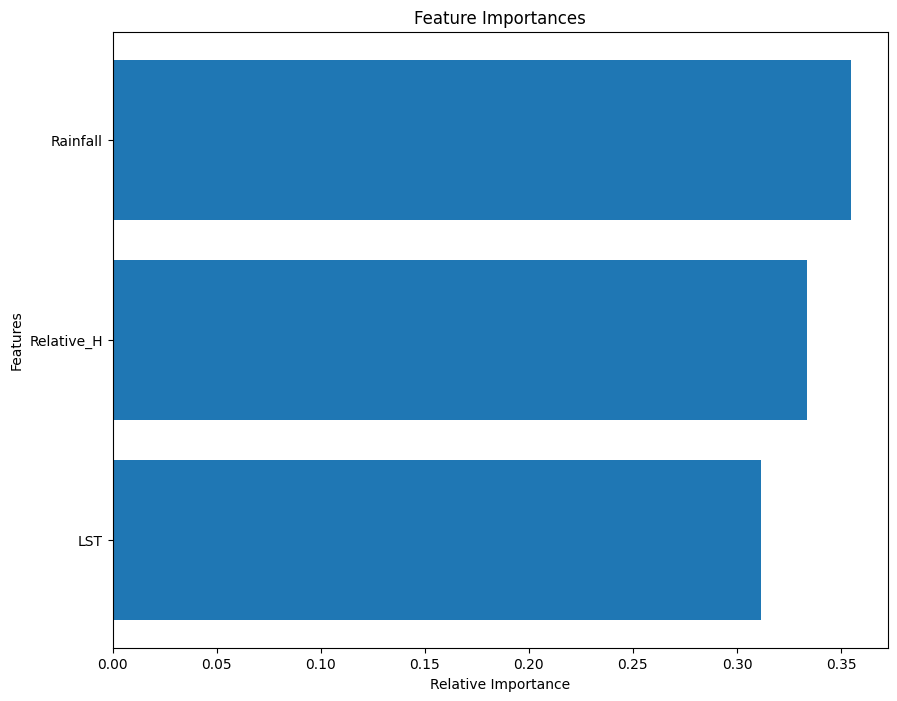

In [ ]:
# Extract feature names and their importance values
features, importance = zip(*sorted_feature_importance)

plt.figure(figsize=(10, 8))
plt.barh(features, importance)
plt.xlabel("Relative Importance")
plt.ylabel("Features")
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

In [ ]:
etr_pred = etr.predict(X_test_scaled)

In [ ]:
# Evaluation metrics

mae = mean_absolute_error(y_test, etr_pred )
mse = mean_squared_error(y_test, etr_pred )
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(y_test, etr_pred )

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"_Root Mean Squared Error (RMSE)_: {rmse}")
print(f"R-squared (R2): {r2}")

Mean Absolute Error (MAE): 4176.792727272727
Mean Squared Error (MSE): 46747094.346763626
_Root Mean Squared Error (RMSE)_: 6837.18467987838
R-squared (R2): -0.006551596062741805


## Decision Tree

In [ ]:
# Define the hyperparameter grid without 'auto' in max_features
dt_param_dist = {
    'max_depth': [None] + list(randint(3, 20).rvs(10)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['sqrt', 'log2', None]  # Removed 'auto'
}

In [ ]:
# Initialize the DecisionTreeRegressor
dt_reg = DecisionTreeRegressor(random_state=200)

# Perform RandomizedSearchCV
dt_random_search = RandomizedSearchCV(
    estimator=dt_reg,
    param_distributions=dt_param_dist,
    n_iter=4,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the model
dt_random_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=200),
                   n_iter=4, n_jobs=-1,
                   param_distributions={'max_depth': [None, 9, 11, 18, 9, 13, 8,
                                                      8, 3, 3, 15],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a9834483a90>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a983bb8eb30>},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [ ]:
# Get the best estimator
best_dt_model = dt_random_search.best_estimator_
print("Best parameters:", dt_random_search.best_params_)

Best parameters: {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 15, 'min_samples_split': 12}


In [ ]:
# Save the model

dump(best_dt_model, 'Models/Non Clinical/model/decision-tree-model.joblib')

['/content/drive/MyDrive/Colab Notebooks/Malaria modeling and Prediction/models/decision-tree-model.joblib']

In [ ]:
# Load the model

best_dt_model = load('Models/Non Clinical/model/decision-tree-model.joblib')

In [ ]:
# Get feature importances from the best model

feature_importances = best_dt_model.feature_importances_

# Sort indices of feature importance in descending order

sorted_indices = np.argsort(feature_importances)[::-1]

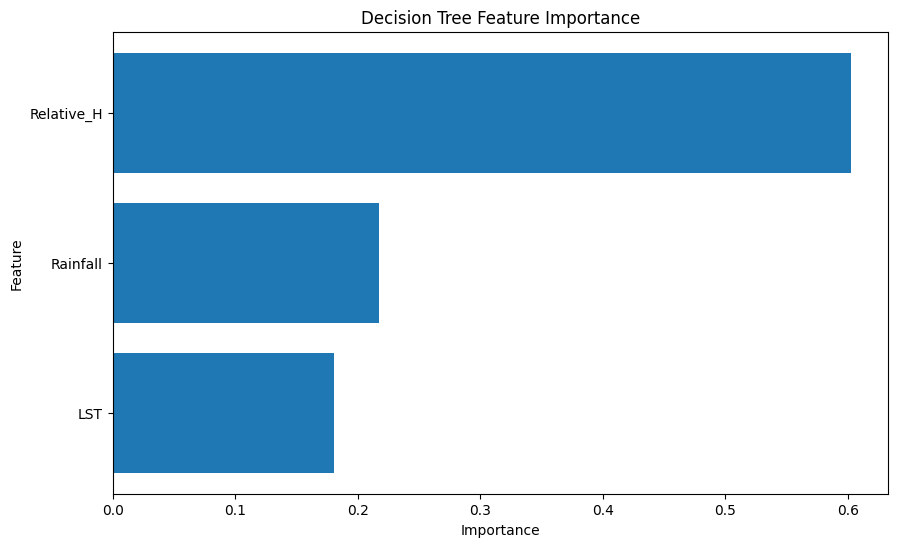

In [ ]:
# The plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances[sorted_indices], align='center')
plt.yticks(range(len(feature_importances)), feature_names[sorted_indices])

# Invert the y-axis to have the highest importance at the top
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Decision Tree Feature Importance')
plt.show()

In [ ]:
dt_model_pred = best_dt_model.predict(X_test_scaled)

In [ ]:
# Evaluation metrics

mae = mean_absolute_error(y_test, dt_model_pred)
mse = mean_squared_error(y_test, dt_model_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(y_test, dt_model_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

Mean Absolute Error (MAE): 4343.647464775045
Mean Squared Error (MSE): 45609311.15231997
Root Mean Squared Error (RMSE): 6753.4666025915885
R-squared (R2): 0.017946985214747135


# Evaluation metrics


|         Models        |        Mean Absolute Error (MAE)           |        Mean Squared Error (MSE)           |       Root Mean Squared Error (RMSE)         |        $R^2$            |
|----------------------|----------------------|----------------------|----------------------|----------------------|
| Random Forest   |       9232.18        |       184648307.49      |       13588.53        |       0.2762        |
| Extreme Gradient Boosting            |        8045.67        |       194084651.35       |       13931.42        |        0.2392        |
| Light Gradient-Boosting Machine           |        11160.98        |       234016195.59       |       15297.58        |       0.0827        |
| Decision Tree  |        10324.80        |       209328138.48      |       14468.17        |       0.1795         |


# Best Performing Model: Random Forest

The Random Forest model has been identified as the best performing model based on the evaluation metrics. Below is the code used to implement the Random Forest regression model, along with its performance metric)
print(f"R^2 Score: {r2:.4f}")


## Prediction for 2024